# Exploratory Data Analysis (EDA) Report

This notebook contains an exploratory data analysis (EDA) for the dataset used in this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import (
    count,
    when,
    col,
    countDistinct,
    first,
    array_contains,
    size,
    sum,
    udf,
)

## Initializing Spark Session

Setting up the Spark environment for large-scale data processing.


In [2]:
MAX_MEMORY = "15G"


conf = (
    SparkConf()
    .setMaster("local[*]")
    .set("spark.executor.heartbeatInterval", 10000)
    .set("spark.network.timeout", 10000)
    .set("spark.core.connection.ack.wait.timeout", "3600")
    .set("spark.executor.memory", MAX_MEMORY)
    .set("spark.driver.memory", MAX_MEMORY)
)


def init_spark():
    spark = (
        SparkSession.builder.appName("Pyspark guide").config(conf=conf).getOrCreate()
    )
    return spark


spark = init_spark()

In [6]:
filename_data = "D:\\Projects\\endomondo_HR.json"
df = spark.read.json(filename_data, mode="FAILFAST")

### Data Overview

In [7]:
df.printSchema()

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)



In [8]:
pd.DataFrame(df.dtypes, columns=["Column Name", "Data type"])

,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


## Data Loading and Cleaning

Loading the dataset and performing initial cleaning steps.

In [9]:
string_columns = ["gender", "sport", "url"]
numeric_columns = ["id", "userId"]
array_columns = [
    "altitude",
    "heart_rate",
    "latitude",
    "longitude",
    "speed",
    "timestamp",
]

missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:
        missing_count = df.filter(
            col(column).eqNullSafe(None) | col(column).isNull()
        ).count()
        missing_values.update({column: missing_count})

    if column in numeric_columns:
        missing_count = df.where(col(column).isin([0, None, np.nan])).count()
        missing_values.update({column: missing_count})

    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(
            array_contains(df[column], 0) | array_contains(df[column], np.nan)
        ).count()
        missing_values.update({column: missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
print(missing_df)

   altitude  gender  heart_rate  id  latitude  longitude  speed  sport  \
0     40848       0        1280   0       113        113   7741      0   

   timestamp  url  userId  
0          0    0       0  


In [10]:
df = df.withColumn("PerWorkoutRecordCount", size(col("timestamp")))

def user_activity_workout_summarize(df):
    user_count = format(df.select("userId").distinct().count(), ",d")
    workout_count = format(df.select("id").distinct().count(), ",d")
    activity_count = str(df.select("sport").distinct().count())

    sum_temp = df.agg(functions.sum("PerWorkoutRecordCount")).toPandas()
    total_records_count = format(sum_temp["sum(PerWorkoutRecordCount)"][0], ",d")

    columns = [
        "Users count",
        "Activity types count",
        "Workouts count",
        "Total records count",
    ]
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]

    gender_user_count = (
        df.select("gender", "userId").distinct().groupBy("gender").count().toPandas()
    )
    gender_activities_count = df.groupBy("gender").count().toPandas()

    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index("gender"),
        on="gender",
        how="inner",
        lsuffix="_gu",
    )
    gender_user_activity_count.columns = [
        "Gender",
        "# of users",
        "Activities (workouts) count",
    ]

    return sum_df, gender_user_activity_count


sum_dfs = user_activity_workout_summarize(df)
print("Overall data set summary on users, workouts and number of records (pre-filtering):")
print(sum_dfs[0])

Overall data set summary on users, workouts and number of records (pre-filtering):
  Users count Activity types count Workouts count Total records count
0       1,104                   49        253,020         111,541,956


In [11]:
print("Number of workouts that have less than 50 records and statistic summary:")
removed_df = (
    df.select("PerWorkoutRecordCount")
    .where(df.PerWorkoutRecordCount < 50)
    .toPandas()
    .describe()
    .astype(int)
)
removed_df.rename(
    columns={"PerWorkoutRecordCount": "PerWorkoutRecordCount <50"}, inplace=True
)
removed_df.T

Number of workouts that have less than 50 records and statistic summary:


,count,mean,std,min,25%,50%,75%,max
PerWorkoutRecordCount <50,5541,23,14,1,11,22,36,49


## Data Exploration

Generating summary statistics and visualizing key insights.

In [12]:
ranked_sport_users_df = (
    df.select(df.sport, df.userId)
    .distinct()
    .groupBy(df.sport)
    .count()
    .orderBy("count", ascending=False)
)

highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()

highest_sport_users_df.rename(columns={"count": "Users count"}, inplace=True)

total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

print(ranked_sport_users_df.collect()[:5])

[Row(sport='run', count=865), Row(sport='bike', count=794), Row(sport='mountain bike', count=336), Row(sport='bike (transport)', count=252), Row(sport='walk', count=209)]


In [13]:
highest_sport_users_df_renamed = highest_sport_users_df.copy()
highest_sport_users_df_renamed["percentage"] = (
    highest_sport_users_df["Users count"] / total_sports_users * 100
)

others_count = total_sports_users - highest_sport_users_df_renamed["Users count"].sum()
others_percentage = 100 - highest_sport_users_df_renamed["percentage"].sum()

others_df = pd.DataFrame(
    [{"sport": "others", "Users count": others_count, "percentage": others_percentage}]
)

highest_sport_users_df_renamed = pd.concat(
    [highest_sport_users_df_renamed, others_df], ignore_index=True
)

print("Top 5 sports that have the most users participated:")
print(highest_sport_users_df_renamed)

Top 5 sports that have the most users participated:
              sport  Users count  percentage
0               run          865   25.130738
1              bike          794   23.067984
2     mountain bike          336    9.761766
3  bike (transport)          252    7.321325
4              walk          209    6.072051
5            others          986   28.646136


C:\Users\piyus\AppData\Local\Temp\ipykernel_19404\77560369.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(sports, rotation="vertical", fontsize="small")


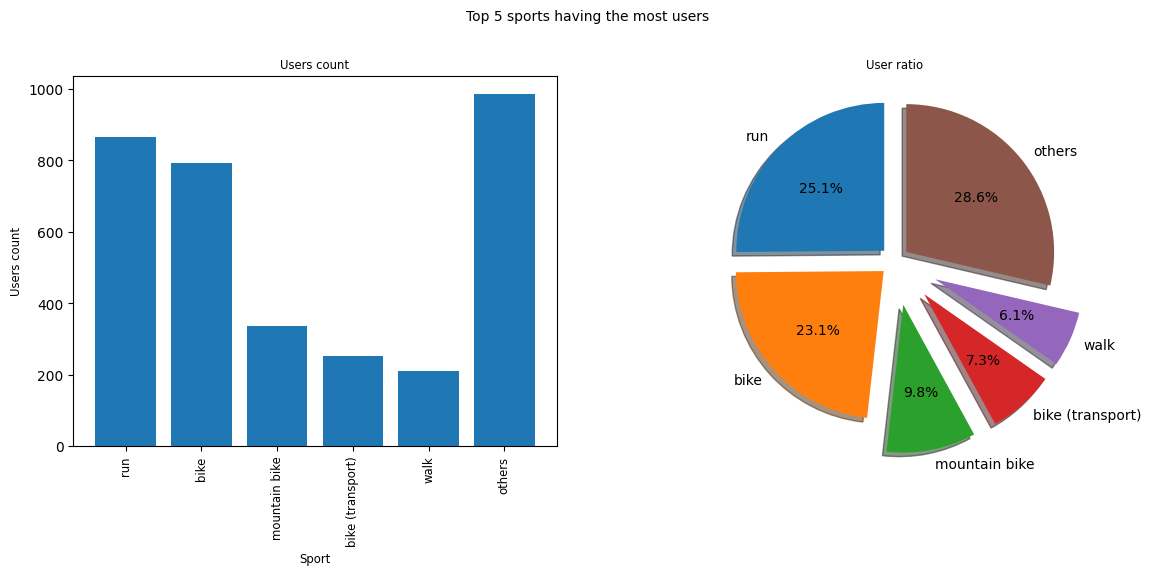

In [14]:
sports = highest_sport_users_df_renamed["sport"].tolist()
users_count = highest_sport_users_df_renamed["Users count"].tolist()
percentages = highest_sport_users_df_renamed["percentage"].tolist()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

axs[0].bar(x=sports, height=users_count)
axs[0].set_title("Users count", fontsize="small")
axs[0].set_xlabel("Sport", fontsize="small")
axs[0].set_ylabel("Users count", fontsize="small")
axs[0].set_xticklabels(sports, rotation="vertical", fontsize="small")

explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
axs[1].set_title("User ratio", fontsize="small")

axs[1].pie(
    x=percentages,
    labels=sports,
    autopct="%1.1f%%",
    shadow=True,
    explode=explode,
    startangle=90,
    radius=1,
)

fig.text(
    0.5,
    1.02,
    "Top 5 sports having the most users",
    ha="center",
    va="top",
    transform=fig.transFigure,
)

plt.show()

In [15]:
activities_by_gender = df.groupBy("sport", "gender").count().toPandas()
activities_by_gender[:5]

,sport,gender,count
0,hiking,female,71
1,core stability training,male,1103
2,run,male,107882
3,kayaking,male,253
4,mountain bike,male,12782


## Feature Engineering

Creating new features and transforming data for better model performance.

There are total: 49 activities and here is the chart for activities based on gender:


C:\Users\piyus\AppData\Local\Temp\ipykernel_19404\3595117567.py:14: FutureWarning: The provided callable <function mean at 0x00000232FE677920> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(np.mean)


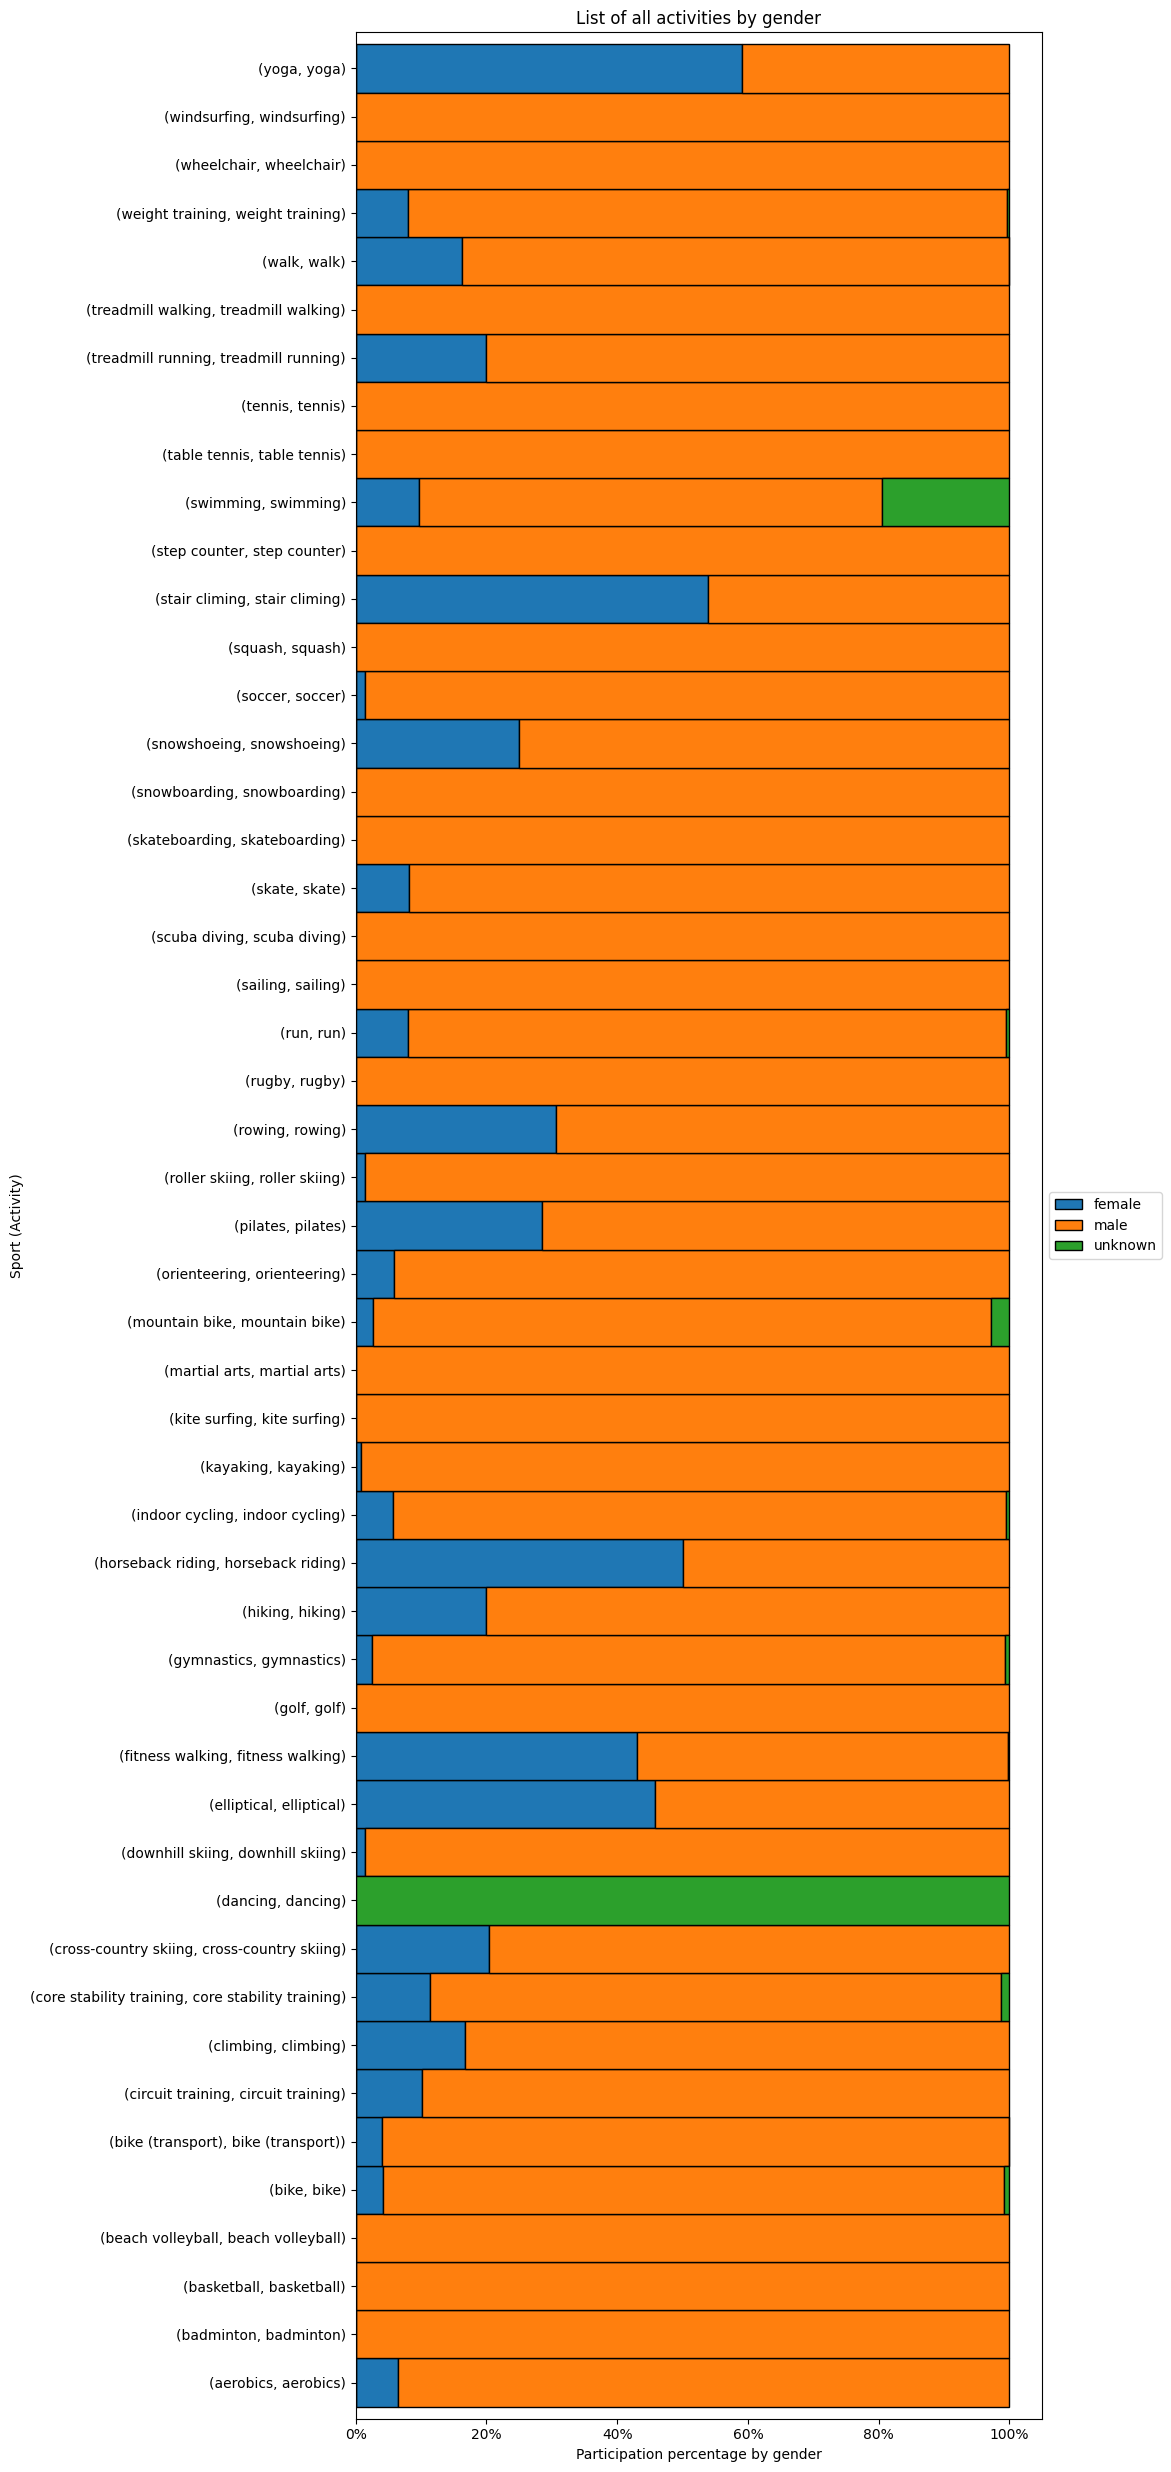

In [16]:
total_activities = ranked_sport_users_df.count()
print(
    f"There are total: {total_activities} activities and here is the chart for activities based on gender:"
)

activities_by_gender = df.groupBy("sport", "gender").count().toPandas()

fig = plt.figure(figsize=(12, 25))
grid_size = (1, 1)
ax = plt.subplot2grid(grid_size, (0, 0), colspan=1, rowspan=1)

plot = (
    activities_by_gender.groupby(["sport", "gender"])
    .agg(np.mean)
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
    .plot(
        kind="barh",
        stacked=True,
        width=1,
        edgecolor="black",
        ax=ax,
        title="List of all activities by gender",
    )
)

ylabel = plt.ylabel("Sport (Activity)")
xlabel = plt.xlabel("Participation percentage by gender")

legend = plt.legend(
    sorted(activities_by_gender["gender"].unique()),
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
)

param_update = plt.rcParams.update({"font.size": 16})

ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter())

a = fig.tight_layout()
plt.show()

In [17]:
activities_by_gender_df = activities_by_gender.pivot_table(
    index="sport", columns="gender", values='count', fill_value=0
).reset_index().rename_axis(None, axis=1)

Top 5 sports that have the most users participated:
              sport  female      male  unknown     total  percentage
0               run  9360.0  107882.0    660.0  117902.0   46.597897
1              bike  4172.0   92966.0    863.0   98001.0   38.732511
2     mountain bike   353.0   12782.0    375.0   13510.0    5.339499
3  bike (transport)   414.0   10030.0      1.0   10445.0    4.128132
5            others  1034.0    8255.0     42.0    9331.0    3.687851
4              walk   626.0    3204.0      1.0    3831.0    1.514110


C:\Users\piyus\AppData\Local\Temp\ipykernel_19404\3172150158.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(top_activities_by_gender_df['sport'], rotation='vertical', fontsize='small')


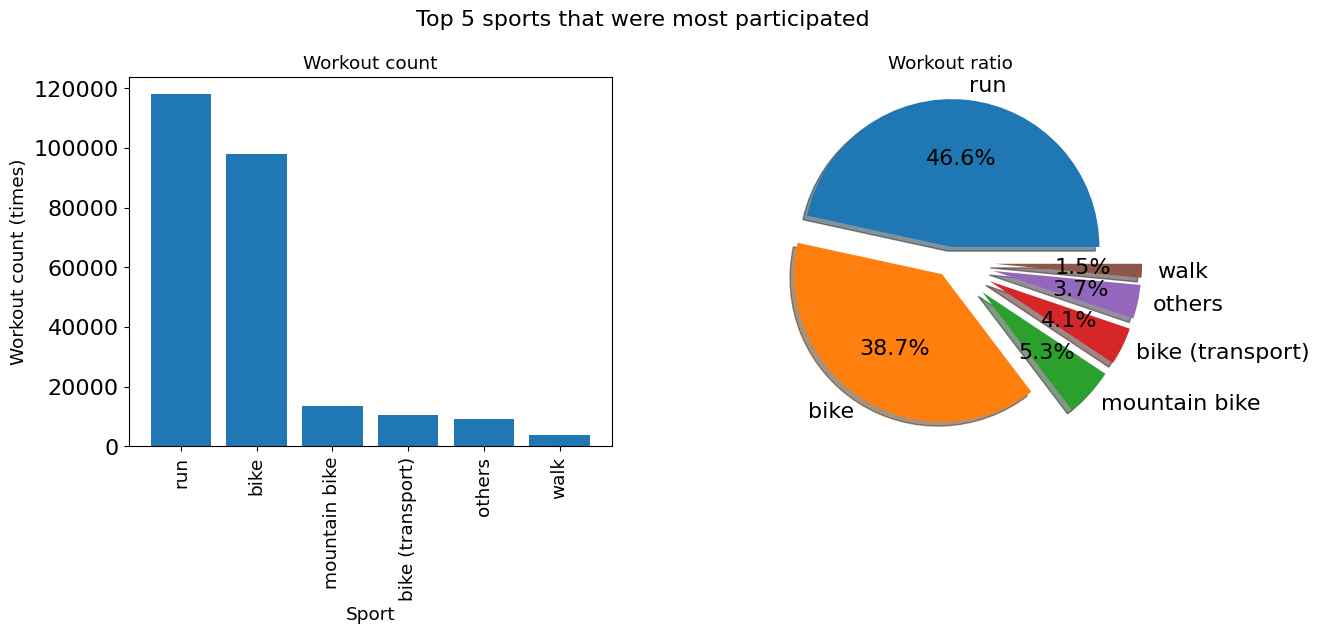

In [18]:
# Calculate total and percentage
activities_by_gender_df['total'] = activities_by_gender_df['male'] + activities_by_gender_df['female'] + activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = (activities_by_gender_df['total'] / activities_by_gender_df['total'].sum() * 100)

# Select the top 5 sports by percentage
top_activities_by_gender_df = activities_by_gender_df.sort_values(by='percentage', ascending=False).head(5)

# Calculate the 'others' category
others = {'sport': 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = activities_by_gender_df[column].sum() - top_activities_by_gender_df[column].sum()
    others[column] = value

# Create a DataFrame for the 'others' category and append it
others_df = pd.DataFrame([others])
top_activities_by_gender_df = pd.concat([top_activities_by_gender_df, others_df], ignore_index=True)

# Sort the final DataFrame by percentage
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(by='percentage', ascending=False)

print('Top 5 sports that have the most users participated:')
print(top_activities_by_gender_df)

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

# Bar plot
axs[0].bar(x=top_activities_by_gender_df['sport'], height=top_activities_by_gender_df['total'])
axs[0].set_title('Workout count', fontsize='small')
axs[0].set_xlabel('Sport', fontsize='small')
axs[0].set_ylabel('Workout count (times)', fontsize='small')
axs[0].set_xticklabels(top_activities_by_gender_df['sport'], rotation='vertical', fontsize='small')

# Pie chart
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
axs[1].set_title('Workout ratio', fontsize='small')
axs[1].pie(
    x=top_activities_by_gender_df['percentage'],
    labels=top_activities_by_gender_df['sport'],
    autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

# Add a centered title above the entire figure
fig.text(0.5, 1.02, 'Top 5 sports that were most participated', ha='center', va='top', transform=fig.transFigure)

# Display the plots
plt.show()

## Conclusion

Summarizing key findings and next steps.

In [20]:
min_number_of_sports = 1

In [21]:
sport_df = df.select(df.userId, df.gender, df.sport).distinct().groupBy(df.userId, df.gender).count()

In [22]:
user_more_sports_df = sport_df.filter(sport_df["count"] > min_number_of_sports).orderBy("count", ascending = False).toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)

In [23]:
user_more_sports_df.describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
userId,822,4860464,3953412,69,1609606,3730685,7554937,15481421
Sports count,822,3,2,2,2,3,5,16


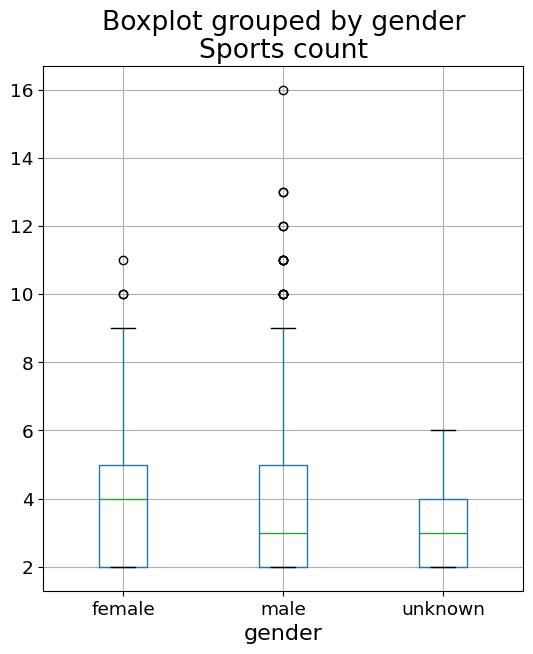

In [24]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))

Plot of workouts distribution by activity type:


C:\Users\piyus\AppData\Local\Temp\ipykernel_19404\1896006140.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(


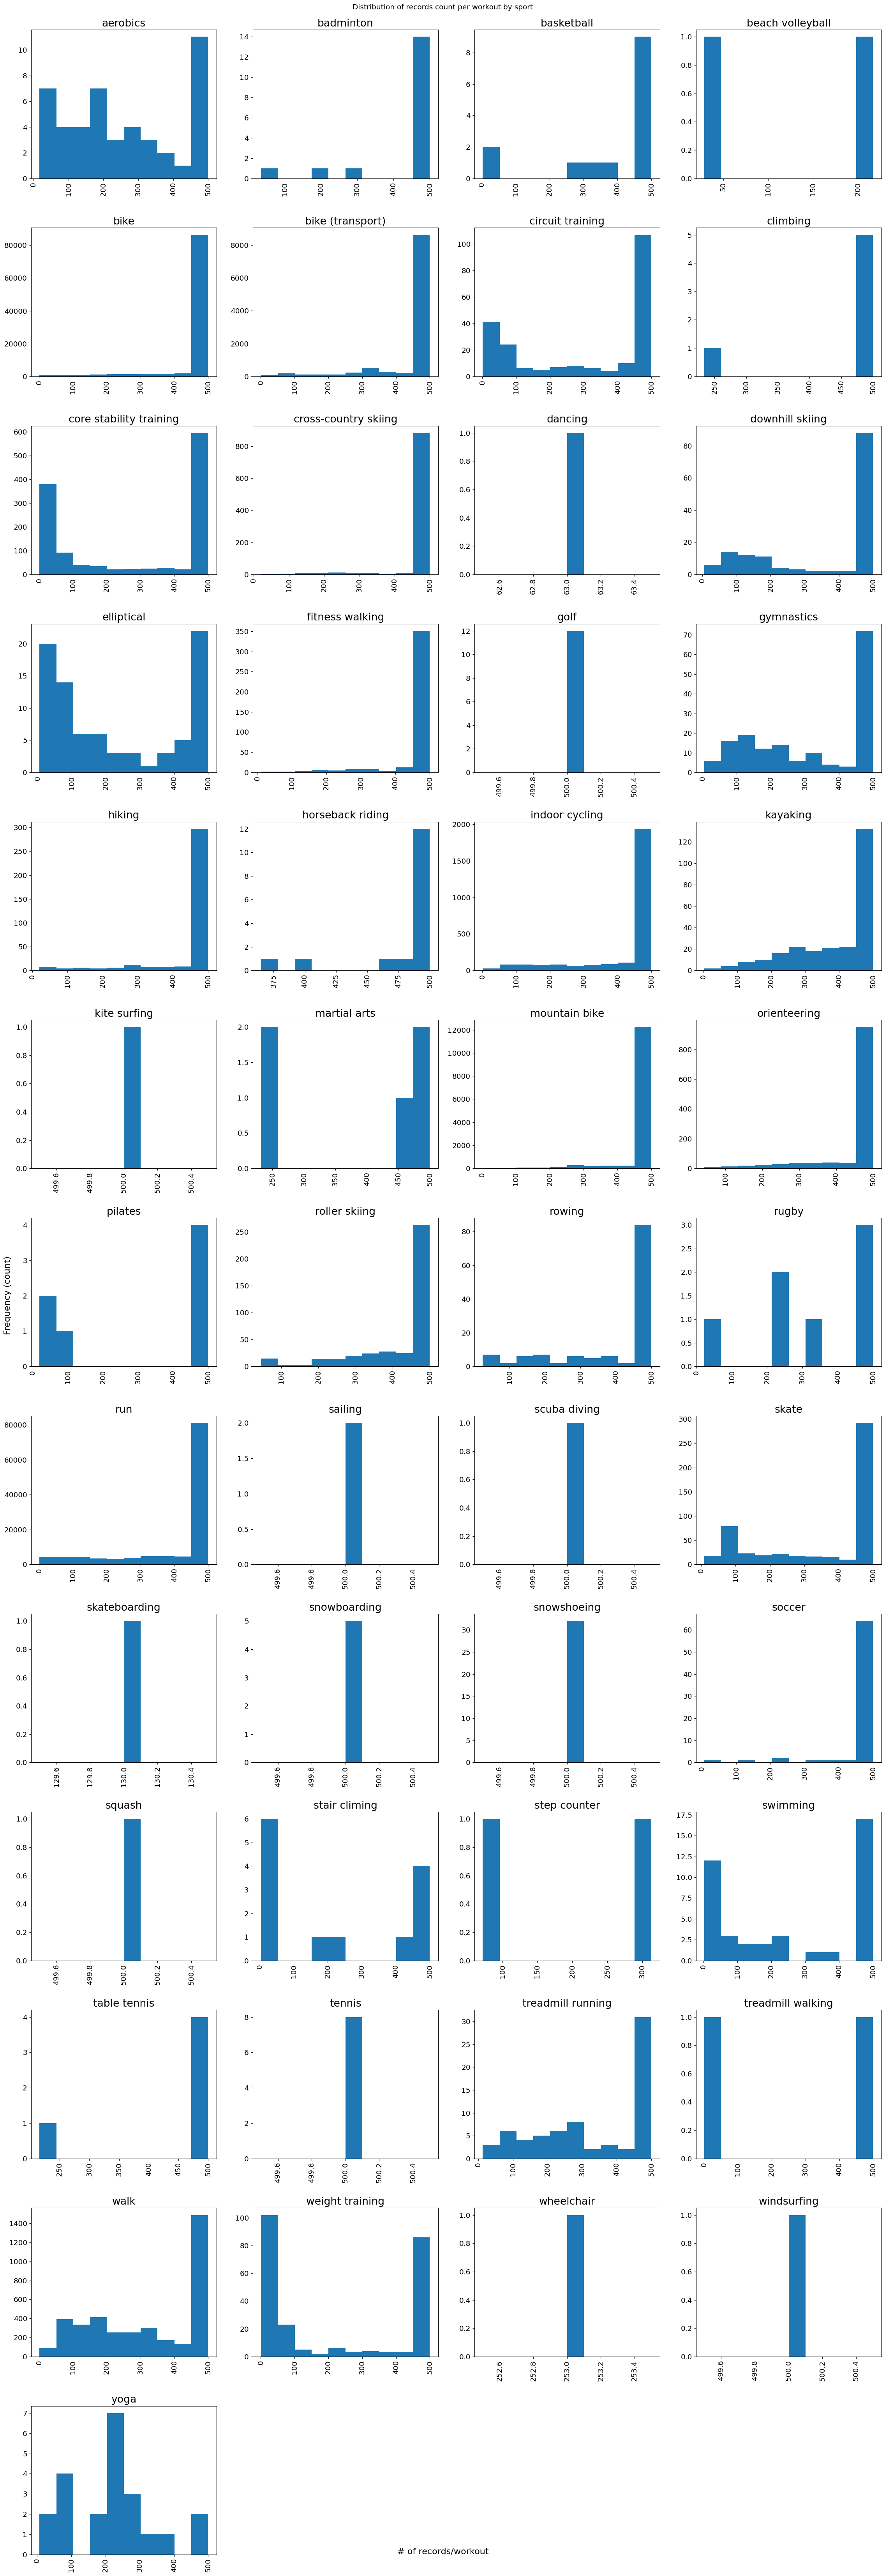

In [25]:
print('Plot of workouts distribution by activity type:')

plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='sport', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()

title = fig.text(0.5, 1, 'Distribution of records count per workout by sport', ha='center', fontsize='small', transform=fig.transFigure)

xlabel = fig.text(
    0.5, 0.01, '# of records/workout', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical')

In [26]:
qualified_df = df.select(df.sport, df.userId, df.gender).groupBy(df.sport, df.userId, df.gender).count()

qualified_df = qualified_df.filter(qualified_df["count"] >= 10).orderBy("count", ascending = False)

In [27]:
print('Number of users having more than 10 workouts:')

qualified_pd_df = qualified_df.select("userId", "gender").distinct().groupBy(qualified_df.gender).count().toPandas()

qualified_pd_df.rename(columns={'count': 'Users count'}, inplace=True)
qualified_pd_df

Number of users having more than 10 workouts:


,gender,Users count
0,unknown,13
1,female,88
2,male,886


In [28]:
qualified_users_count = qualified_pd_df['Users count'].sum()

total_users_count = df.select('userId').distinct().count()

qualified_percentage = round((qualified_users_count / total_users_count),2) * 100
print('So there is {} / {} of users qualifying the 10 historical records criteria, which is {:.2f}%'.format(qualified_users_count, total_users_count, qualified_percentage))

So there is 987 / 1104 of users qualifying the 10 historical records criteria, which is 89.00%


## Dataset Overview

The dataset contains workout information with 11 columns including user demographics and workout specifics. The data is stored in a Spark DataFrame with various array-based columns for metrics like altitude, heart rate, latitude, longitude, speed, and timestamps.

## Workout Record Statistics

- **Total Workouts with <50 Records**: 5,541
- **Record Count Metrics**:
  - Mean: 23 records
  - Median: 22 records
  - Range: 1-49 records
  - Standard Deviation: 14

## Sports Distribution

| Sport | Gender | Count |
|-------|--------|-------|
| Run | Male | 107,882 |
| Mountain Bike | Male | 12,782 |
| Core Stability Training | Male | 1,103 |
| Kayaking | Male | 253 |
| Hiking | Female | 71 |

## User Demographics

- **Total Unique Users**: 822
- **Gender Breakdown**:
  - Male: 886 users
  - Female: 88 users
  - Unknown: 13 users

## User ID and Sports Participation

- **User ID Range**: 69 to 15,481,421
- **Mean User ID**: 4,860,464
- **Sports per User**:
  - Mean: 3 sports
  - Maximum: 16 sports
  - Minimum: 2 sports
